Reference: 
1. https://www.kaggle.com/code/valentinwerner/915-deberta3base-training?scriptVersionId=161278765
2. https://www.kaggle.com/code/kenjikonno/pii-distillbert-training
3. https://huggingface.co/learn/nlp-course/en/chapter7/2
4. [generate-data](https://www.kaggle.com/code/minhsienweng/create-ai-generated-essays-using-llm)



To dos:
1. [done]use org train data to do train test split
2. [done]add stride (stride on train and keep the validation same)
3. [p1][done]build own tokenizer (4 epoch | larger vocab size)
4. [done]use test tokenizer
5. [done]generate more data
6. similar data from test
7. model ensembles
8. [p1][done] inference stride
9. [p1][done] match up 0.945 results
10.[done] set truncation to [false](https://www.kaggle.com/code/ilya2raev/957-deberta3base-training).
11. [p1]regex. Can detect URLs & ID Nums
12.[x]add new tokens from training.
13. [p1]match 0.962
14. [done]v3-large with more data
15. freeze 6 layers and flex embeddings


URLs:

1. http://www.burns-lopez.com/categories/appabout.asp
2. http://jacobs-fisher.com/listpost.html
3. https://www.youtube.com/watch?v=n-ajTPJ1h-J
4. tps://www.facebook.com/bclark


ID-NUM:


1.B-ID_NUM : 860632713425
2. B-ID_NUM : 530670102508
3. B-ID_NUM : 530670102508
4. B-ID_NUM : Iz.:999893751750

## Q&A

__*Why the labels need to collate to have the same length for different docs?*__

Collate to the same length in each batch.

__*What's the difference between tokenizer with no truncation and tokenize with stride but truncated?*__


__*Does training a new tokenizer help?*__

The pretrained model are closely tied with the pretrained tokenizer, as the `input_ids` of of each token will map to an embedding vector for model training. 

Training a new tokenizer might disrupt the `input_ids`, the same word that maps to `input_ids=3`, after training might map to `input_ids=511`, which the model is unaware of, leading to misalignment. Normally it requires more fine-tunning with larger data set to accommodate this.

## Versions

- __256train + 2048inference__: validation Recall: 0.81 | Precision: 0.88 | F1: 0.81 -> 0.664
- __1024train + 2048inference + 3epoch__: validation Recall: 0.81 | Precision: 0.9 | F1: 0.82 -> 0.874
- __stride(512, 214) + 512train + 2048inference + 2epoch__: validation Recall: 0.86 | Precision: 0.88 | F1: 0.867 -> 0.736
- __stride(512, 214) + 1024train + 2048inference + 2epoch__: validation Recall: 0.84 | Precision: 0.88 | F1: 0.84 -> 0.862
- __stride(700, 200) + 1024train + 2048inference + 2epoch__: validation Recall: 0.84 | Precision: 0.89 | F1: 0.84 -> 0.863
- __stride(700, 200) + 1024train + 1024inference + 2epoch__: validation Recall: 0.84 | Precision: 0.89 | F1: 0.84 -> 0.82
- __stride(700, 200) + 1024train + inference(1024, 400) + 2epoch__: validation Recall: 0.84 | Precision: 0.89 | F1: 0.84 -> 0.894
- __stride(700, 200) + 1024train + inference(2048, 400) + 2epoch__: validation Recall: 0.84 | Precision: 0.89 | F1: 0.84 -> 0.896
- __external_data + 1024train + inference(1024, 400) + 3epoch__: validation Recall: 0.991 | Precision: 0.983 | F1: 0.990 -> 0.945 (2048 infer does not work)
- __external_data + stride(1024/700, 200) + 1024train + 1024inference + 3epoch__: validation Recall: 0.991 | Precision: 0.982 | F1: 0.990 -> 0.936 (1024 stride does not work)
- __external_data + add_token + train(1024, 1024) + inference(1024, 400) + 3epoch__: validation Recall: 0.98 | Precision: 0.97 | F1: 0.98 -> 0.903
- __external_data + add_test_token + train(1024) + inference(1024, 400) + 4epoch__: 0.884
- __own_gen_data + external_data + train(1024) + inference(trunc=False) + 4epoch__: 0.951


In [1]:
!pip install seqeval -q

import json
from itertools import chain
from functools import partial
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification
from datasets import Dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
from seqeval.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [21]:
# ['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', '
# B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 
# 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL', 'O']

# cnt = 0
# for _, row in data.iterrows():
#     tok, label = row['tokens'], row['labels']
#     for i, tk in enumerate(tok):
#         lb: str = label[i]
#         if lb.endswith("ID_NUM"):
#             print(lb, tk)
#         if lb.endswith("URL_PERSONAL"):
#             print(lb, tk)
#             cnt += 1
#     if cnt >= 20:
#         break

B-URL_PERSONAL https://www.jackson.com/list/explorehomepage.htm
B-URL_PERSONAL https://www.linkedin.com/in/mmartinez
B-URL_PERSONAL https://youtu.be/rFD2lJuvace
B-ID_NUM 860632713425
B-ID_NUM 530670102508
B-ID_NUM 530670102508
B-ID_NUM 875673967537
B-ID_NUM 860632713425
B-ID_NUM 557349702179
B-ID_NUM 784372734211
B-ID_NUM 054176622314
B-ID_NUM 674915248960
B-URL_PERSONAL https://www.hall.biz/wp-contenthome.html
B-URL_PERSONAL http://www.burns-lopez.com/categories/appabout.asp
B-URL_PERSONAL http://jacobs-fisher.com/listpost.html
B-URL_PERSONAL https://www.youtube.com/watch?v=n-ajTPJ1h-J
B-ID_NUM 932353568953
B-URL_PERSONAL tps://www.facebook.com/bclark
B-URL_PERSONAL https://www.youtube.com/channel/UC1ElAcppeuhfet
I-URL_PERSONAL nYZqnhEXw
B-URL_PERSONAL https://oconnell-townsend.com/wp-content/categorieshomepage.html
B-ID_NUM 982645662261
B-ID_NUM 409046248321
B-URL_PERSONAL https://www.peterson.net/tag/app/listmain.php
B-URL_PERSONAL https://diaz.com/tag/wp-contentlogin.htm
B-URL_PERS

# Config

In [2]:
class Config:
    seed = 2024
    offline_validation = False
    submit = True
    
    origin_path = "/kaggle/input/pii-detection-removal-from-educational-data/train.json"
    external_path1 = "/kaggle/input/fix-punctuation-tokenization-external-dataset/pii_dataset_fixed.json"
    external_path2 = "/kaggle/input/fix-punctuation-tokenization-external-dataset/moredata_dataset_fixed.json"
    gen_path1 = "/kaggle/input/create-ai-generated-essays-using-llm/pii_dataset_Gemma.json"
    gen_path2 = "/kaggle/input/k/zhangyue199/create-ai-generated-essays-using-llm/pii_dataset_Gemma.json"


    TRAINING_MODEL_PATH = "microsoft/deberta-v3-base"
#     TRAINING_MODEL_PATH = "/kaggle/input/save-debertav3-base" + "/deberta-v3-base"
    TRAINING_MAX_LENGTH = 1024
    TRAINING_EPOCH = 5
    
    STRIDE_MAX_LENTH = 1024
    STRIDE_STEP = 400
    
    TRAIN_TOKENIZER = False
    VOCAB_SIZE = 30000
    
    
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)

seed_everything(Config.seed)

## import dataset and downsample

In [17]:
def read_json(path):
    return json.load(open(path))


def count_negative_positive_doc(data):
    p = n = 0
    positive = []
    negative = [] 
    for d in tqdm(data, desc="preprocess data"):
        # some corrupted data
        if type(d) != dict:
            continue
        if any(np.array(d["labels"]) != "O"): 
            p += 1
            positive.append(d)
        else:
            n += 1
            negative.append(d)
    print(f"positive samples {p} | negative samples {n}")
    return positive, negative
    

# quantile 0.5: 700 | 0.75: 900 | 0.9: 1100
# data = pd.DataFrame(read_json(Config.origin_path))  # positive samples 945/6807
data_org = read_json(Config.origin_path)
pos, neg = count_negative_positive_doc(data_org)
data_ext1 = read_json(Config.external_path1)
data_ext2 = read_json(Config.external_path2)

gen1 = pd.DataFrame(read_json(Config.gen_path1))
gen2 = pd.DataFrame(read_json(Config.gen_path2))
# gen = pd.concat([gen1, gen2, gen2], axis=0).to_dict(orient='records')
# positive samples 5568 | negative samples 911


print("size data origin", len(data_org), "data external1", len(data_ext1), 
      "data external2", len(data_ext2), "gemma generated: ", len(gen1) + len(gen2) + len(gen2))

data1 = pd.DataFrame(pos + neg[:len(neg)//3] + data_ext1 + data_ext2)
data = pd.concat([data1, gen1, gen2, gen2], axis=0)
data['document'] = data['document'].astype(str)
data.reset_index(drop=True, inplace=True)
# data = pd.DataFrame(data_org)
print("merged size", len(data))

preprocess data: 100%|██████████| 6807/6807 [00:01<00:00, 4008.29it/s]


positive samples 945 | negative samples 5862
size data origin 6807 data external1 4434 data external2 2000 gemma generated:  6479
merged size 15812


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='tokens', ylabel='Count'>

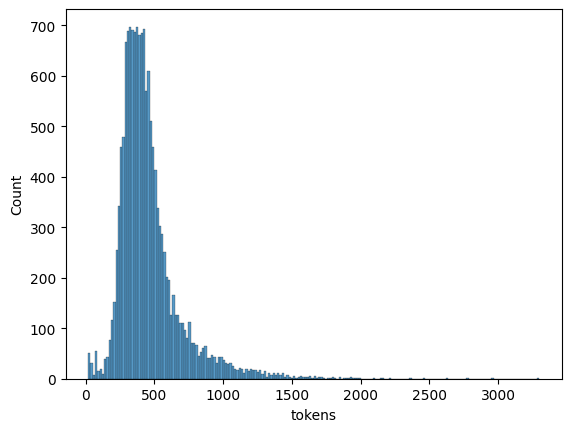

In [4]:
import seaborn as sns

sns.histplot(data['tokens'].apply(lambda x: len(x)))

# Preprocessing

## Define Validation Set

In [5]:
def encode_labels(data):
    data['unique_labels'] = data['labels'].apply(lambda x: set(l.split('-')[1] if l != 'O' else 'O' for l in x))
    mlb = MultiLabelBinarizer()
    
    arr = mlb.fit_transform(data['unique_labels'])
    label_df = pd.DataFrame(arr, columns=mlb.classes_)
    return pd.concat([data, label_df], axis=1), mlb.classes_


def count_labels(data, labels):
    label_cnt = dict()
    for label in c:
        doc_cnt = data[label].sum()
        label_cnt[label] = doc_cnt
        print(f"{label}: {doc_cnt}")
    return label_cnt

In [6]:
labeled_data, c = encode_labels(data)

In [7]:
print("Data size", labeled_data.shape)
label_cnt = count_labels(labeled_data, c)
    
VAL_RATE = 0.1
labeled_data['validation'] = 0
for label, cnt in label_cnt.items():
    sample_size = int(cnt * VAL_RATE)
    ind = labeled_data[labeled_data[label] == 1].sample(sample_size, random_state=Config.seed).index
    labeled_data.loc[ind, 'validation'] = 1

if Config.offline_validation:
    val_data = labeled_data[labeled_data['validation'] == 1]
    train_data = labeled_data[labeled_data['validation'] == 0]
    print("\nValidation set size", val_data.shape, 'Train set size', train_data.shape)
    _ = count_labels(val_data, c)

Data size (14812, 14)
EMAIL: 6393
ID_NUM: 2808
NAME_STUDENT: 8534
O: 14812
PHONE_NUM: 7454
STREET_ADDRESS: 8404
URL_PERSONAL: 2686
USERNAME: 3741


## Stride

In [8]:
def split_stride(df: pd.DataFrame, max_length, step):
    # no stride
    return df
    new_df = []
    for _, row in df.iterrows():
        token_len = len(row['tokens'])
        if token_len > max_length:
            start = 0
            while start < token_len:
                if start + max_length > token_len:
                    new_row = {
                        'document': row['document'],
                        'full_text': "",
                        'tokens': row['tokens'][token_len-max_length:token_len],
                        'trailing_whitespace': row['trailing_whitespace'][token_len-max_length:token_len],
                        'labels': row['labels'][token_len-max_length:token_len],
                    }
                    start += max_length
                else:
                    new_row = {
                        'document': row['document'],
                        'full_text': "",
                        'tokens': row['tokens'][start:start+max_length],
                        'trailing_whitespace': row['trailing_whitespace'][start:start+max_length],
                        'labels': row['labels'][start:start+max_length],
                    }
                    start += step
                new_df.append(new_row)
        else:
            new_row = {
                'document': row['document'],
                'full_text': row['full_text'],
                'tokens': row['tokens'],
                'trailing_whitespace': row['trailing_whitespace'],
                'labels': row['labels'],
            }
            new_df.append(new_row)
    return pd.DataFrame(new_df)

In [10]:
# Split stride only on train data so that we use the same validation set for reference
if Config.offline_validation:
    print("Train size", train_data.shape)
    train_data_stride = split_stride(train_data, Config.STRIDE_MAX_LENTH, Config.STRIDE_STEP)
    print("After striding size", train_data_stride.shape)

In [11]:
print("Whole data size", labeled_data.shape)
labeled_data_stride = split_stride(labeled_data, Config.STRIDE_MAX_LENTH, Config.STRIDE_STEP)
print("After striding size", labeled_data_stride.shape)

Whole data size (14812, 15)
After striding size (14812, 15)


### labels

In [12]:
# * unpack the list of labels and chain together
all_labels = sorted(list(set(chain(*[x for x in data.labels]))))
print(f"all_labels:{all_labels}")

label2id = {l: i for i,l in enumerate(all_labels)}
id2label = {v:k for k,v in label2id.items()}

all_labels:['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL', 'O']


## Tokenizer

In [13]:
txt = "This isn't an example"
tokenizer = AutoTokenizer.from_pretrained(Config.TRAINING_MODEL_PATH)
print("Old tokenizer:\n", tokenizer.tokenize(txt))

if Config.TRAIN_TOKENIZER:
    # Use only the original data for training tokenizer
    text = [x['full_text'] for x in data_org]
    data_corpus = (text[i:i+1000] for i in range(0, len(text), 1000))
    tokenizer_new = tokenizer.train_new_from_iterator(data_corpus, vocab_size=Config.VOCAB_SIZE)
    print("New tokenizer:\n", tokenizer_new.tokenize(txt))

    # Add new tokens to existing vocab
    tokens_new = set()
    for tk in tokenizer_new.vocab.keys():
        if tokenizer.convert_tokens_to_ids(tk) == tokenizer.unk_token_id:
            tokens_new.add(tk)

    print("Added unknown tokens", len(tokens_new))
    tokenizer.add_tokens(list(tokens_new))

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Old tokenizer:
 ['▁This', '▁isn', "'", 't', '▁an', '▁example']


# Offline Validation

## Tokenizer

The tokenizer returns multiple keys
```
tokenizer(text, return_offsets_mapping=True, max_length=max_length)
```

1. __input_ids__: The `id` of the token in the vocabulary.
2. __token_type_ids__: This is used in question answering training, where the question sequence will be marked as `0` and answer sequence with `1`.
3. __attention_mask__: Tells the model which tokens to attend to, the original tokens will be marked `1`, the padded will be marked `0`.
4. __offset_mapping__: a tuple of `(start_idx, end_idx)` corresponds to the token position. `(0, 0)` indicates the start and end.

Results with `max_length` number of tokens will be returned, for sentence shorter than it will be padded, longer ones will be truncated.

In [14]:
# This tokenize the sentence and align tokenized token with a label derived from the original label.
def tokenize(doc, tokenizer, label2id, max_length):
    text = []
    labels = []
    
    # give each char a label
    for t, l, ws in zip(doc["tokens"], doc["provided_labels"], doc["trailing_whitespace"]):
        text.append(t)
        labels.extend([l] * len(t))

        if ws:
            text.append(" ")
            labels.append("O")

    text = "".join(text)
    labels = np.array(labels)
     
    tokenized = tokenizer(text, return_offsets_mapping=True, max_length=max_length)
#     tokenized = tokenizer(text, return_offsets_mapping=True, truncation=False)
    token_labels = []
    for start_idx, end_idx in tokenized.offset_mapping:
        # start token
        if start_idx == 0 and end_idx == 0:
            token_labels.append(label2id["O"])
            continue

        if text[start_idx].isspace():
            start_idx += 1
        # TODO: maybe for a token that splits into multiple ones, the later ones should be I-Class?
        token_labels.append(label2id[labels[start_idx]])

    return {**tokenized, "labels": token_labels, "length": len(tokenized.input_ids)}


def tokenize_data_from_pandas(data, tokenizer):
    data['provided_labels'] = data['labels']
    ds = Dataset.from_pandas(data)

    ds = ds.map(tokenize,
                fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": Config.TRAINING_MAX_LENGTH}, 
                num_proc=2)
    return ds

In [15]:
# tokenizer = AutoTokenizer.from_pretrained(Config.TRAINING_MODEL_PATH)
if Config.offline_validation:
    print("Tokenize train data ...")
    # Here uses strided train data
    ds_train = tokenize_data_from_pandas(train_data_stride, tokenizer)
    print("Tokenize validation data ...")
    ds_val = tokenize_data_from_pandas(val_data, tokenizer)
    
if Config.submit:
    print("Tokenize whole data ...")
    ds = tokenize_data_from_pandas(labeled_data, tokenizer)

Tokenize whole data ...
   

#0:   0%|          | 0/7406 [00:00<?, ?ex/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#1:   0%|          | 0/7406 [00:00<?, ?ex/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


### Metric

In [ ]:
def compute_metrics(p, all_labels):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    recall = recall_score(true_labels, true_predictions)
    precision = precision_score(true_labels, true_predictions)
    f_score = (1 + 5*5) * recall * precision / (5*5*precision + recall)
    
    results = {
        'recall': recall,
        'precision': precision,
        'f1': f_score
    }
    return results

### Model and parameter

In [ ]:
# classification model
def init_model():
    model = AutoModelForTokenClassification.from_pretrained(
        Config.TRAINING_MODEL_PATH,
        num_labels=len(all_labels),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )
    # for adding new tokenizer
    if Config.TRAIN_TOKENIZER:
        model.resize_token_embeddings(len(tokenizer))
    return model

# collate the individual data samples and pad to the same length in each batch
# pad_to_multiple_of padding strategy is useful for training on NVIDIA cores
collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

## Arguments

- fp16: this enables mixed-precision training, which can reduce memory usage and speed up training, provided that your hardware supports it (e.g., modern NVIDIA GPUs with Tensor Cores).
- learning_rate: The initial learning rate for the optimizer. The value 5e-5 is a common starting point for many NLP tasks and models.
- num_train_epochs: The total number of training epochs to run. __An epoch is a complete pass through the entire training dataset.__

- per_device_train_batch_size: The batch size per device during training. If you're using multiple GPUs, each will process this many examples per step.

- gradient_accumulation_steps: This parameter allows you to accumulate gradients over multiple steps before performing an optimization step. It effectively increases the batch size without increasing the memory requirement.

- evaluation_strategy: Determines when evaluation is performed if do_eval is set to True. Options are "steps", "no", "epoch".

- save_total_limit: The maximum number of model checkpoints to save. Older checkpoints are deleted to save space if this limit is exceeded. Setting it to 1 means only the most recent checkpoint is kept.

- logging_steps: The number of training steps between logging events. It controls how often progress logs are printed out.

- lr_scheduler_type: Specifies the type of learning rate scheduler to use. The 'cosine' scheduler type adjusts the learning rate based on a cosine curve, which can lead to better performance by smoothly decreasing the learning rate.

- metric_for_best_model: This parameter is used to identify the best model during training when evaluation is performed. It specifies which metric to use for this purpose. In this case, "f1" suggests that the F1 score is used to evaluate model performance.

- greater_is_better: Indicates whether a higher value of the metric_for_best_model is better. Setting it to True means that higher F1 scores indicate better models.

- warmup_ratio: The proportion of training steps to perform linear learning rate warm-up. For example, __0.1 means the learning rate will gradually increase over the first 10% of the total training steps__ before following the specified scheduler.

- weight_decay: This adds a L2 penalty to the cost, which can help prevent the model from overfitting on the training data. A value of 0.01 applies a small amount of regularization.


# Validation

In [ ]:
%%time
if Config.offline_validation:
    print("Offline validation")
    model = init_model()
    args = TrainingArguments(
        output_dir="output", 
        fp16=True,
        learning_rate=5e-5,
        num_train_epochs=Config.TRAINING_EPOCH,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=2,
        report_to="none",
        evaluation_strategy="steps",
        do_eval=True,
        eval_steps=500,
        save_total_limit=1,
        logging_steps=50,
        lr_scheduler_type='cosine',
        metric_for_best_model="f1",
        greater_is_better=True,
        warmup_ratio=0.1,
        weight_decay=0.01  # L2 reg
    )
    trainer = Trainer(
        model=model, 
        args=args, 
        train_dataset=ds_train,
        eval_dataset=ds_val,
        data_collator=collator, 
        tokenizer=tokenizer,
        compute_metrics=partial(compute_metrics, all_labels=all_labels),
    )

    # Recall Precision F1 are from validation set
    trainer.train()

# Full Training

In [ ]:
if Config.submit:
    print("Online submission")
    model = init_model()
    args = TrainingArguments(
        output_dir="output", 
        fp16=True,
        learning_rate=2e-5, # use lower lr
        num_train_epochs=Config.TRAINING_EPOCH,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=2,
        report_to="none",
        evaluation_strategy="no",
        do_eval=True,
        save_total_limit=1,
        logging_steps=200,
        lr_scheduler_type='cosine',
        metric_for_best_model="f1",
        greater_is_better=True,
        warmup_ratio=0.1,
        weight_decay=0.01
    )

    trainer = Trainer(
        model=model, 
        args=args, 
        train_dataset=ds,
        data_collator=collator, 
        tokenizer=tokenizer,
        compute_metrics=partial(compute_metrics, all_labels=all_labels),
    )

    trainer.train()
    
    print("Saving model ...")
    name = f"debertaV3_len{Config.TRAINING_MAX_LENGTH}_epoch{Config.TRAINING_EPOCH}"
    trainer.save_model(name)
    tokenizer.save_pretrained(name)